In [192]:
from collections import defaultdict
import itertools
import random
import pandas as pd
from ceat import ceat_meta
import numpy as np
from embeddings import generate_embedding, generate_embedding_bulk, visualize_embeddings

Set random seed

In [193]:
random.seed(42)

# Use baby names dataset for choosing female, male and neutral names

In [321]:

def load_names_from_baby_names(random_groups = False):
    random.seed(42)
    # CSV file with columns "year","name","percent","sex", get the top 1000 names for "boy" and "girl"
    f = "baby-names.csv"
    
    # Load all data from the file
    data = pd.read_csv(f)
    # Sum each row for name and sex
    data = data.groupby( ["name", "sex"] ).sum().reset_index()
    # Sort by percent
    data = data.sort_values(by='percent', ascending=False)
    print(len(data))
    # Only continue with top 1000 names
    data = data[:4000]
    

    males = data[data["sex"] == "boy"]
    females = data[data["sex"] == "girl"]

    
    data = pd.merge(males, females, on=["name"], how="outer")
    # Add ratio column
    data["total"] = data["percent_x"] + data["percent_y"]
    data["male_ratio"] = data["percent_x"] / (data["total"])
    
    data["distance"] = abs(data["male_ratio"] - 0.5)
    data["m_score"] = data["percent_x"] * data["distance"]
    data["f_score"] = data["percent_y"] * data["distance"]
    

    # Filter intersect where distance is less than 10%
    intersect = data[data["distance"] < 0.05]
    # Sort by distance from 1 
    intersect = intersect.sort_values(by='distance', ascending=True)

    if not random_groups:
        # Order by most male names
        data = data.sort_values(by='m_score', ascending=False)
        males_subset = data[:20] 
    else:
        males_subset = data.sample(n=20, random_state=random.randint(0,1000), weights="percent_x")
    
    if not random_groups:
        # Order by most female names
        data = data.sort_values(by='f_score', ascending=False)
        females_subset = data[:20]
    else:
        females_subset = data.sample(n=20, random_state=random.randint(0,1000), weights="percent_y")
        
    
    intersect_subset = intersect[:min(20,len(intersect))]
    # print(intersect_subset)
    # print(f"Number of names in intersect: {len(intersect)}, {intersect_subset}")
    assert abs(intersect["percent_x"].sum() - intersect["percent_y"].sum()) / len(intersect) < 0.01

    # Return array of top 1000 names
    man_array = males_subset["name"].values
    female_array = females_subset["name"].values
    nonbinary_array = intersect_subset["name"].values
    return (man_array,female_array, nonbinary_array), data

# Load occupations from occupations.csv, this is some list of occupations I found online.

In [216]:
def load_occupations(random_groups=False):
    f = "inc_occ_gender.csv"
    # Has format Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
    data = pd.read_csv(f)
    # Remove data where Occupation is all caps
    data = data[~data["Occupation"].str.isupper()]
    # Remove functions that have more than two twords
    data = data[data["Occupation"].apply(lambda x: len(x.split(" ")) <= 3)]
    
    # Sort by All_workers and get top 100
    data = data.sort_values(by='All_workers', ascending=False)
    data = data[:100]

    # Replace all plural words with singular
    # Add space after each occupation
    data["Occupation"] = data["Occupation"].apply(lambda x: x + " ")
    data["Occupation"] = data["Occupation"].apply(lambda x: x.replace("s "," "))
    # Remove trailing spaces
    data["Occupation"] = data["Occupation"].apply(lambda x: x.strip())    

    # Add a collumn that has M_workers/F_workers
    
    data["ratio"] = data["M_workers"] / data["F_workers"]
    # Sort by ratio
    if not random_groups:
        data = data.sort_values(by='ratio', ascending=False)

    # Get top occupations for both genders
    top_m = data[:10]["Occupation"].values
    top_f = data[-10:]["Occupation"].values

    # Also get top ten of most fair occupations
    data["distance"] = abs(data["ratio"] - 1)
    data = data.sort_values(by='distance', ascending=True)
    # print(data[:10])
    top_fair = data[:10]["Occupation"].values
    return (top_m,top_f,top_fair) ,data
    

In [322]:
(MALE_NAMES,FEMALE_NAMES,NEUTRAL_NAMES), raw_NAME_DATA = load_names_from_baby_names()
print(MALE_NAMES,FEMALE_NAMES,NEUTRAL_NAMES)

# Print row
# print(raw_NAME_DATA[raw_NAME_DATA["name"] == "Kris"])

7455
['John' 'James' 'William' 'Robert' 'Charles' 'Michael' 'Joseph' 'David'
 'George' 'Thomas' 'Richard' 'Edward' 'Frank' 'Daniel' 'Paul' 'Donald'
 'Christopher' 'Henry' 'Walter' 'Anthony'] ['Mary' 'Elizabeth' 'Margaret' 'Helen' 'Anna' 'Dorothy' 'Barbara'
 'Patricia' 'Ruth' 'Linda' 'Jennifer' 'Betty' 'Alice' 'Marie' 'Frances'
 'Emma' 'Florence' 'Rose' 'Grace' 'Mildred'] ['Kris' 'Maxie' 'Kerry' 'Devyn' 'Peyton' 'Gale' 'Jackie' 'Justice' 'Avery'
 'Kendall' 'Trinidad' 'Jaime' 'Lacy' 'Leslie' 'Pat']


In [258]:
(MALE_OCUPATIONS,FEMALE_OCCUPATIONS, NEUTRAL_OCCUPATIONS), raw_OCCUPATION_DATA = load_occupations()
print(MALE_OCUPATIONS,FEMALE_OCCUPATIONS, NEUTRAL_OCCUPATIONS)
SENTENCE_TEMPLATES = [
    "{name} is a {attribute}",
    # "{name} is someone's {attribute}",
    "{name} works as a {attribute}",
    "{name} retired from being a {attribute}",
]

['Highway maintenance worker' 'Roofer' 'Carpenter' 'Construction laborer'
 'Electrician' 'Ground maintenance worker' 'Machinist'
 'Sheet metal worker' 'Firefighter' 'Mechanical engineer'] ['Teller' 'Registered nurse' 'Dietitian and nutritionist'
 'Nurse practitioner' 'Medical assistant' 'Teacher assistant'
 'Dental assistant' 'Dental hygienist' 'Childcare worker'
 'Speech-language pathologist'] ['Designer' 'Financial manager' 'Food service manager'
 'Advertising sale agent' 'Operation research analyst' 'Pharmacist'
 'Food preparation worker' 'Baker' 'Writer and author'
 'Compliance officer']


# Generate sentences and create a dataframe that has all sentences

In [259]:
def generate_sentences(names, attributes = pd.concat([pd.Series(MALE_OCUPATIONS),pd.Series(FEMALE_OCCUPATIONS), pd.Series(NEUTRAL_OCCUPATIONS)])):
    sentences = {}
    # Create all possible combinations of attribute, noun and sentence template
    triplets = list(itertools.product(attributes, names, SENTENCE_TEMPLATES))
    for (a, n, st) in triplets:
        sentence = st.format(name=n, attribute=a)
        sentences[(a,n,st)] = sentence
    return sentences

In [260]:
neutral_sentence_dict = generate_sentences(names=NEUTRAL_NAMES)
male_sentence_dict = generate_sentences(names=MALE_NAMES)
female_sentence_dict = generate_sentences(names=FEMALE_NAMES)

In [261]:
pd_neutral = pd.DataFrame([(k[0],k[1],k[2],v,"X") for k,v in neutral_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])
pd_f = pd.DataFrame([(k[0],k[1],k[2],v,"F") for k, v in female_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])
pd_m = pd.DataFrame([(k[0],k[1],k[2],v,"M") for k, v in male_sentence_dict.items()], columns=["attribute","name","sentence_template","sentence", "group"])

In [262]:
pd_all = pd.concat([pd_neutral,pd_f,pd_m])
pd_all = pd_all.reset_index()
pd_all.to_csv("dataset_pd_all.csv")

Print total sentence tokens

In [263]:
total_sentence_tokens = pd_all["sentence"].apply(lambda x: len(x.split(" "))).sum()
print(f"Total sentence tokens(make sure this is not too much for OpenAI): {total_sentence_tokens}")
assert total_sentence_tokens < 1000000 # Make sure we are not over the limit, this is a rough estimate of 13 cents.


Total sentence tokens(make sure this is not too much for OpenAI): 29700


# Acquire embeddings for all sentences, code can use some cleaning up

Create dictionary copy of pd_all

In [264]:
pd_all_to_dict = pd_all.to_dict(orient="index")

In [265]:
distinct_attributes = pd_all["attribute"].unique()
distinct_groups = pd_all["group"].unique()

In [266]:
for a in distinct_attributes:
    for g in distinct_groups:
        print(f"Attribute: {a}, Group: {g}")
        data_a_g = pd_all[(pd_all["attribute"] == a) & (pd_all["group"] == g)]
        
        embedding_str_pairs = generate_embedding_bulk(sentences=data_a_g["sentence"].values,save_to_file=True)
        assert len(embedding_str_pairs) == len(data_a_g)
        for ((i, row),(sentence, embedding)) in zip(data_a_g.iterrows(),embedding_str_pairs):
            assert row["sentence"] == sentence              

            # Store array in pd_all_to_dict
            pd_all_to_dict[i]["embedding"] = np.array(embedding)

Attribute: Highway maintenance worker, Group: X
From cache: 45, To compute: 0
Attribute: Highway maintenance worker, Group: F
From cache: 60, To compute: 0
Attribute: Highway maintenance worker, Group: M
From cache: 60, To compute: 0
Attribute: Roofer, Group: X
From cache: 45, To compute: 0
Attribute: Roofer, Group: F
From cache: 60, To compute: 0
Attribute: Roofer, Group: M
From cache: 60, To compute: 0
Attribute: Carpenter, Group: X
From cache: 45, To compute: 0
Attribute: Carpenter, Group: F
From cache: 60, To compute: 0
Attribute: Carpenter, Group: M
From cache: 60, To compute: 0
Attribute: Construction laborer, Group: X
From cache: 45, To compute: 0
Attribute: Construction laborer, Group: F
From cache: 60, To compute: 0
Attribute: Construction laborer, Group: M
From cache: 60, To compute: 0
Attribute: Electrician, Group: X
From cache: 45, To compute: 0
Attribute: Electrician, Group: F
From cache: 60, To compute: 0
Attribute: Electrician, Group: M
From cache: 60, To compute: 0
Attr

# Statistics on embeddings

In [308]:
def get_cosine_sim(vec1, vec2):
    return np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_cosine_similarity_for_attribute(a,avg_a_g):
    cos_x_f = get_cosine_sim(avg_a_g[("X",a)],avg_a_g[("F",a)])
    cos_x_m = get_cosine_sim(avg_a_g[("X",a)],avg_a_g[("M",a)])
    avg_a_g_fm = (avg_a_g[("F",a)] + avg_a_g[("M",a)]) / 2
    cos_x_fmmean = np.dot(avg_a_g[("X",a)],avg_a_g_fm) / (np.linalg.norm(avg_a_g[("X",a)]) * np.linalg.norm(avg_a_g_fm))
    # print(f"Attribute: {a}, Cosine similarity between X and F: {cos_x_f}, Cosine similarity between X and M: {cos_x_m}")
    return (cos_x_f,cos_x_m, cos_x_fmmean)

In [317]:
average_embedding_g_a = defaultdict(list)
for (i,row) in pd_all_to_dict.items():
    embedding = row["embedding"]
    average_embedding_g_a[(row["group"],row["attribute"])].append(embedding)
    # if row["group"] != "X":
        # average_embedding_g_a[("X",row["attribute"])].append(embedding)

average_embedding_g_a = {k: np.mean(v,axis=0).squeeze() for k,v in average_embedding_g_a.items()}


In [318]:
cosine_similarities_a = {}
for a in distinct_attributes:
    (cos_x_f,cos_x_m, cos_x_fm) =get_cosine_similarity_for_attribute(a,average_embedding_g_a)
    cosine_similarities_a[a] = (cos_x_f,cos_x_m, cos_x_fm)



## Plot cosine similarity of F and M to X per attribute 

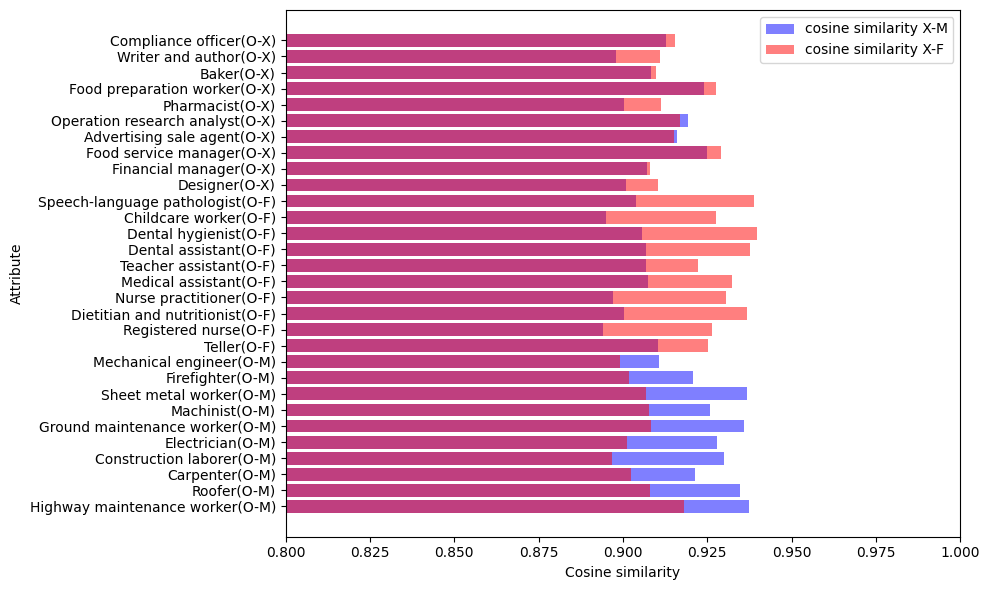

In [319]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
def_get_group_of_key = lambda k: "O-F" if k in FEMALE_OCCUPATIONS else ("O-M" if k in MALE_OCUPATIONS else "O-X")

cos_keys = list([ k + f"({def_get_group_of_key(k)})" for k in cosine_similarities_a.keys()])
ax.barh(cos_keys, [v[1] for v in cosine_similarities_a.values()], color='b', alpha=0.5, label='cosine similarity X-M')
ax.barh(cos_keys, [v[0] for v in cosine_similarities_a.values()], color='r', alpha=0.5, label='cosine similarity X-F')

# ax.barh(cos_keys, [v[2] for v in cosine_similarities.values()], color='g', alpha=0.2, label='cosine similarity X-avg(F+M)')
ax.legend()
ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Attribute")
plt.xlim(.8, 1)
# Adjust the layout to prevent labels from falling off
plt.tight_layout()
plt.savefig("cosine_similarities.png")


## Plot difference in cosine similarities against raw_OCCUPATION_DATA for employment ratio of males/ (total)

R^2: 0.9120989159274909


/tmp/ipykernel_47371/1290046025.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


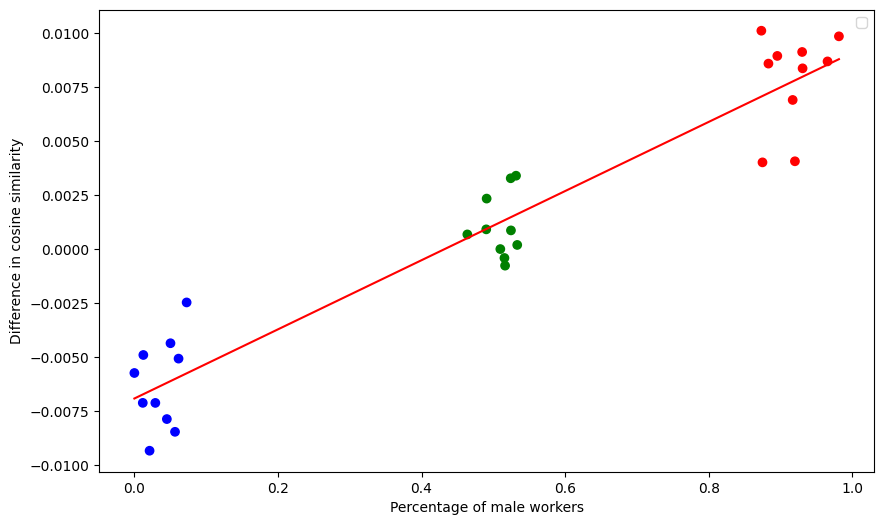

In [ ]:
from sklearn.linear_model import LinearRegression


fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
key_data = [raw_OCCUPATION_DATA[raw_OCCUPATION_DATA["Occupation"] == a] for a in cosine_similarities_a.keys()]
male_ratio = [data["F_workers"].values[0] / data["All_workers"].values[0] for data in key_data]
colors = ['r' if key["Occupation"].values[0] in FEMALE_OCCUPATIONS else 'b' if key["Occupation"].values[0] in MALE_OCUPATIONS else 'g' for key in key_data]
assert len(colors) == len(male_ratio)
ax.scatter(male_ratio, [v[0] - v[1] for v in cosine_similarities_a.values()], c=colors )
ax.set_xlabel("Percentage of male workers")
ax.set_ylabel("Difference in cosine similarity")
plt.legend()
# Display linear regression line of best fit
# Fit linear regression
X = np.array(male_ratio).reshape(-1, 1)
y = np.array([v[0] - v[1] for v in cosine_similarities_a.values()])
model = LinearRegression()
model.fit(X, y)
line_x = np.linspace(min(male_ratio), max(male_ratio), 100)
line_y = model.predict(line_x.reshape(-1, 1))

# get likelihood of the model
r_sq = model.score(X, y)
print(f"R^2: {r_sq}")


# Plot linear regression line
ax.plot(line_x, line_y, color='red')


plt.savefig("cosine_similarities_diff.png")

## Plot difference in cosine similarities against raw_NAME_DATA and it's male_ratio

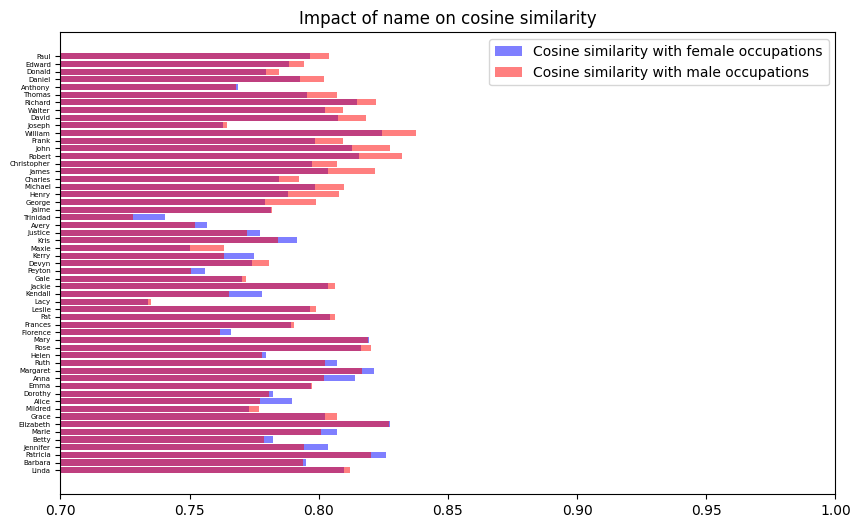

In [ ]:
average_embedding_a_n = defaultdict(list)
for (i,row) in pd_all_to_dict.items():
    embedding = row["embedding"]
    average_embedding_a_n[(row["name"],row["attribute"])].append(embedding)

average_embedding_a_n = {k: np.mean(v,axis=0).squeeze() for k,v in average_embedding_a_n.items()}

averages_for_names = {}
distinct_names = set(name for (name,_) in average_embedding_a_n.keys())
# Order names by male_ratio
ordered_names = sorted(distinct_names, key=lambda x: raw_NAME_DATA[raw_NAME_DATA["name"] == x]["male_ratio"].values[0])
for name in ordered_names:
    cosine_similarities_n_m = []
    cosine_similarities_n_f = []
    for a in distinct_attributes:
        cox_x_n = get_cosine_sim(average_embedding_a_n[(name,a)],average_embedding_g_a[("X",a)])
        if a in MALE_OCUPATIONS:
            cosine_similarities_n_m.append(cox_x_n)
        elif a in FEMALE_OCCUPATIONS:
            cosine_similarities_n_f.append(cox_x_n)

    avg_n_f = np.mean(cosine_similarities_n_f)
    avg_n_m = np.mean(cosine_similarities_n_m)
    averages_for_names[name] = (avg_n_f,avg_n_m)
    
        
        
### Plot average difference in cosine similarities against raw_NAME_DATA and it's male_ratio
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
key_data = [raw_NAME_DATA[raw_NAME_DATA["name"] == n] for n in ordered_names]
vals = [v[0] - v[1] for v in averages_for_names.values()]
f_vals = [v[0] for v in averages_for_names.values()]
m_vals = [v[1] for v in averages_for_names.values()]
names = [key["name"].values[0] for key in key_data]
ax.barh(names, f_vals, color='b', alpha=0.5, label='Cosine similarity with female occupations')
ax.barh(names, [v for v in m_vals], color='r', alpha=0.5, label='Cosine similarity with male occupations')
# ax.barh(names, [(v*10) for v in vals ], color='g', alpha=0.5, label='Difference in cosine similarity (*100)')
# Start plot at .7
plt.xlim(.7, 1)
# Make font of y-axis smaller
plt.yticks(fontsize=5)
plt.title("Impact of name on cosine similarity")
plt.legend()


/home/stijn/.local/share/virtualenvs/embedding_fairness-jysr1dE_/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/tmp/ipykernel_47371/2698466755.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


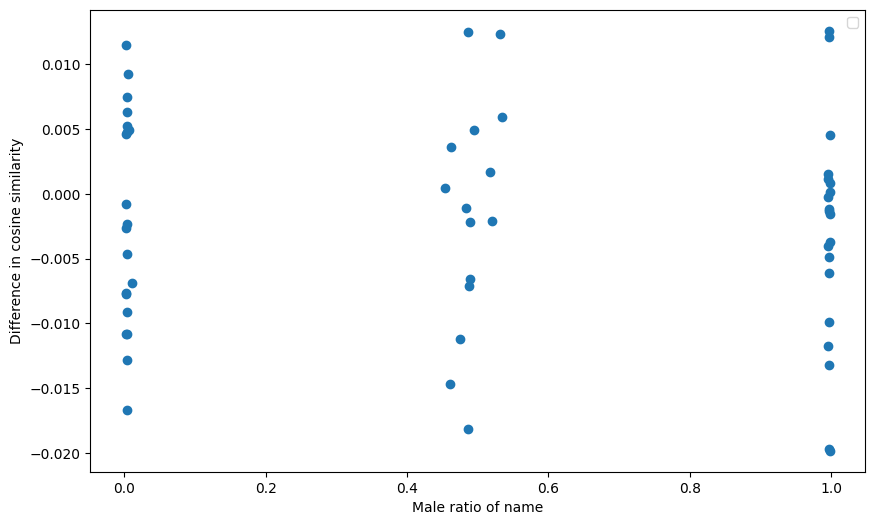

In [ ]:
## Plot distribution likeliness of names against difference in cosine similarities
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the chart
key_data = [raw_NAME_DATA[raw_NAME_DATA["name"] == n] for n in set(name for (name,_) in average_embedding_a_n.keys())]
vals = [v[0] - v[1] for v in averages_for_names.values()]
f_vals = [v[0] for v in averages_for_names.values()]
m_vals = [v[1] for v in averages_for_names.values()]
name_m_ratio = [v["male_ratio"] for v in key_data]
ax.scatter( name_m_ratio, vals)
ax.set_xlabel("Male ratio of name")
ax.set_ylabel("Difference in cosine similarity")
plt.legend()


In [320]:
sent2emb = defaultdict(list)
for emb in pd_all_to_dict.values():
    sent2emb[emb["name"]].append(emb["embedding"])
    sent2emb[emb["attribute"]].append(emb["embedding"])
print(ceat_meta([[FEMALE_NAMES,MALE_NAMES,FEMALE_OCCUPATIONS,MALE_OCUPATIONS]],sent2emb,N = 1000))

tao>0
(0.26292805549009585, 8.288192117097029e-86)
